In [1]:
%load_ext autoreload
%autoreload

In [2]:
import torch
import numpy as np
from gromo.tools import *
from gromo.low_rank_linear_regression import *
from typing import Callable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorly as tl
tl.set_backend('pytorch')

I tested different methods to compute the new neuronns ie to solve:
$$\min_{A, O} ||Y - X A O||_F$$

- the one from the TINY paper (ie SVD of $S^{-1/2}N$ then multiply back with $S^{-1/2}N$)
- the simple SVD of $S^{-1}N$
- the one from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4191838/pdf/nihms497477.pdf (i will call it SXYZ) which is basically getting the SVD of $X = UDV^T$ then extracting the first vectors from the SVD of $V D^{-1} U^T Y$ (and slight variation that do not seems to change much) (Note that this include the SVD of a matrix of size $n \times p$ where $n$ is the number of sample, the time complexity is still linear in $n$ but it is more expensive in practice. On an other point, this does not allow to compute the tensor $S$ by batch so $X$ should fit in memory)


I generated the data with $x_{i,j} \sim N(0, 1)$,  $a_{i,j} \sim N(0, 1)$, $O_{i, j} \sim N(0, 1)$ and $Y = X A O + N(0, 10^{-3})$.

If the number of sample is low ($n=20$ but $p=200$ (input size) and $d=100$ (output size)), the SXYZ give better results, then the TINY and finally the SVD. If the number of sample is high ($n=p\times d$) all the methods give the approximately the same results (even if the TINY is slightly worse).

In [3]:
def gen_data(n: int, p: int, d: int, k: int, seed: int | None = None, float_type=torch.float64) -> tuple[torch.Tensor, torch.Tensor]:
    true_a = torch.randn(p, k, dtype=float_type)
    true_b = torch.randn(k, d, dtype=float_type)

    x = torch.randn(n, p, dtype=float_type)
    w = torch.randn(p, p, dtype=float_type)
    x = x @ w
    x *= 10 * torch.rand(p, dtype=float_type)
    y = x @ true_a @ true_b + (1e-3) * torch.randn(n, d, dtype=float_type)
    return x, y


In [4]:
def test_methods(n: int, 
                 p: int, 
                 d: int, 
                 k: int, 
                 methods: dict[str, Callable[[torch.Tensor, torch.Tensor, int], tuple[torch.Tensor, torch.Tensor]]], 
                 samples: int = 100,
                 float_type=torch.float64,
                 gpu: bool = False):
    results = {name: np.zeros(samples) for name in methods.keys()}
    for i in range(samples):
        x, y = gen_data(n, p, d, k, seed=i, float_type=float_type)
        if gpu and torch.cuda.is_available():
            x = x.to(device=torch.device('cuda'))
            y = y.to(device=torch.device('cuda'))
        for name, method in methods.items():
            a, b = method(x, y, k)
            results[name][i] = value(x, y, a, b) / np.sqrt(n * p)
    return results

In [5]:
methods = {
    "TINY": solve_tiny,
    "TINY N": solve_tiny_normalized,
    "SXYZ": solve_nih,
    "SVD": solve_svd_l2,
    # "SVD tl": solve_svd_l2_tl,
    # "SVD pi": solve_svd_l2_pinv,
    # "SXYZ no proj": lambda x, y, k: solve_nih(x, y, k, option=1),
    # "SXYZ permute proj trunc": lambda x, y, k: solve_nih(x, y, k, option=2)
}

p = 100
d = 100
k = 1

In [6]:
agglomerate_results = dict()
gpu = False
for tf in [torch.float32, torch.float64]:
    for n in [20, 250, p * d, 10 * p * d]:
        results = test_methods(n, p, d, k, methods, float_type=tf, gpu=gpu)
        print(f"type: {tf}, n = {n}, p = {p}, d = {d}, k = {k}, device: {'GPU' if gpu and torch.cuda.is_available() else 'CPU'}")
        print('-' * 10)
        results_avg = {name: res.mean() for name, res in results.items()}
        best_avg = min(results_avg.values())
        best_method = [name for name, res in results.items() if res.mean() == best_avg][0]
        
        for name, res in results.items():
            print(f"{name}:\t\t{res.mean():.3e} (this / best = {res.mean() / best_avg:.1e}) {'(BEST)' if name == best_method else ''}")
        print()
        agglomerate_results[(tf, n)] = results

type: torch.float32, n = 20, p = 100, d = 100, k = 1, device: CPU
----------
TINY:		4.334e-01 (this / best = 4.2e+02) 
TINY N:		1.268e+00 (this / best = 1.2e+03) 
SXYZ:		1.057e-03 (this / best = 1.0e+00) 
SVD:		1.024e-03 (this / best = 1.0e+00) (BEST)

type: torch.float32, n = 250, p = 100, d = 100, k = 1, device: CPU
----------
TINY:		8.949e-02 (this / best = 7.7e+01) 
TINY N:		8.296e-02 (this / best = 7.2e+01) 
SXYZ:		1.156e-03 (this / best = 1.0e+00) (BEST)
SVD:		6.717e+00 (this / best = 5.8e+03) 

type: torch.float32, n = 10000, p = 100, d = 100, k = 1, device: CPU
----------
TINY:		7.854e-02 (this / best = 6.8e+01) 
TINY N:		1.318e-01 (this / best = 1.1e+02) 
SXYZ:		1.163e-03 (this / best = 1.0e+00) (BEST)
SVD:		3.962e+00 (this / best = 3.4e+03) 

type: torch.float32, n = 100000, p = 100, d = 100, k = 1, device: CPU
----------
TINY:		9.965e-02 (this / best = 8.4e+01) 
TINY N:		1.014e-01 (this / best = 8.6e+01) 
SXYZ:		1.185e-03 (this / best = 1.0e+00) (BEST)
SVD:		4.567e+00 (this 

In [ ]:
agglomerate_results = dict()
gpu = torch.cuda.is_available()
for tf in [torch.float32, torch.float64]:
    for n in [20, 250, p * d, 10 * p * d]:
        results = test_methods(n, p, d, k, methods, float_type=tf, gpu=gpu)
        print(f"type: {tf}, n = {n}, p = {p}, d = {d}, k = {k}, device: {'GPU' if gpu and torch.cuda.is_available() else 'CPU'}")
        print('-' * 10)
        results_avg = {name: res.mean() for name, res in results.items()}
        best_avg = min(results_avg.values())
        best_method = [name for name, res in results.items() if res.mean() == best_avg][0]
        
        for name, res in results.items():
            print(f"{name}:\t{res.mean():.3e} (this / best = {res.mean() / best_avg:.1e}) {'(BEST)' if name == best_method else ''}")
        print()
        agglomerate_results[(tf, n)] = results

type: torch.float32, n = 20, p = 100, d = 100, k = 10
----------
TINY:	1.586e+01 (this / best = 1.4e+03) 
SXYZ:	1.134e-02 (this / best = 1.0e+00) (BEST)
SVD:	1.750e+05 (this / best = 1.5e+07) 

type: torch.float32, n = 250, p = 100, d = 100, k = 10
----------
TINY:	6.528e-01 (this / best = 3.4e+01) 
SXYZ:	1.930e-02 (this / best = 1.0e+00) (BEST)
SVD:	5.701e+01 (this / best = 3.0e+03) 

type: torch.float32, n = 10000, p = 100, d = 100, k = 10
----------
TINY:	4.608e-01 (this / best = 2.3e+01) 
SXYZ:	1.990e-02 (this / best = 1.0e+00) (BEST)
SVD:	4.972e+01 (this / best = 2.5e+03) 

type: torch.float32, n = 100000, p = 100, d = 100, k = 10
----------
TINY:	8.370e-01 (this / best = 4.4e+01) 
SXYZ:	1.884e-02 (this / best = 1.0e+00) (BEST)
SVD:	1.799e+02 (this / best = 9.5e+03) 

type: torch.float64, n = 20, p = 100, d = 100, k = 10
----------
TINY:	6.758e-04 (this / best = 1.0e+00) 
SXYZ:	6.716e-04 (this / best = 1.0e+00) (BEST)
SVD:	8.165e-04 (this / best = 1.2e+00) 

type: torch.float64, n

In [ ]:
agglomerate_results = dict()
gpu = torch.cuda.is_available()
for tf in [torch.float32, torch.float64]:
    for n in [20, 250, p * d, 10 * p * d]:
        results = test_methods(n, p, d, k, methods, float_type=tf, gpu=gpu)
        print(f"type: {tf}, n = {n}, p = {p}, d = {d}, k = {k}, device: {'GPU' if gpu and torch.cuda.is_available() else 'CPU'}")
        print('-' * 10)
        results_avg = {name: res.mean() for name, res in results.items()}
        best_avg = min(results_avg.values())
        best_method = [name for name, res in results.items() if res.mean() == best_avg][0]
        
        for name, res in results.items():
            print(f"{name}:\t{res.mean():.3e} (this / best = {res.mean() / best_avg:.1e}) {'(BEST)' if name == best_method else ''}")
        print()
        agglomerate_results[(tf, n)] = results

type: torch.float32, n = 20, p = 100, d = 100, k = 10
----------
TINY:	1.586e+01 (this / best = 1.4e+03) 
SXYZ:	1.134e-02 (this / best = 1.0e+00) (BEST)
SVD:	1.750e+05 (this / best = 1.5e+07) 

type: torch.float32, n = 250, p = 100, d = 100, k = 10
----------
TINY:	6.528e-01 (this / best = 3.4e+01) 
SXYZ:	1.930e-02 (this / best = 1.0e+00) (BEST)
SVD:	5.701e+01 (this / best = 3.0e+03) 

type: torch.float32, n = 10000, p = 100, d = 100, k = 10
----------
TINY:	4.608e-01 (this / best = 2.3e+01) 
SXYZ:	1.990e-02 (this / best = 1.0e+00) (BEST)
SVD:	4.972e+01 (this / best = 2.5e+03) 

type: torch.float32, n = 100000, p = 100, d = 100, k = 10
----------
TINY:	8.370e-01 (this / best = 4.4e+01) 
SXYZ:	1.884e-02 (this / best = 1.0e+00) (BEST)
SVD:	1.799e+02 (this / best = 9.5e+03) 

type: torch.float64, n = 20, p = 100, d = 100, k = 10
----------
TINY:	6.758e-04 (this / best = 1.0e+00) 
SXYZ:	6.716e-04 (this / best = 1.0e+00) (BEST)
SVD:	8.165e-04 (this / best = 1.2e+00) 

type: torch.float64, n

min: 1.16e-02, max: 1.50e+04


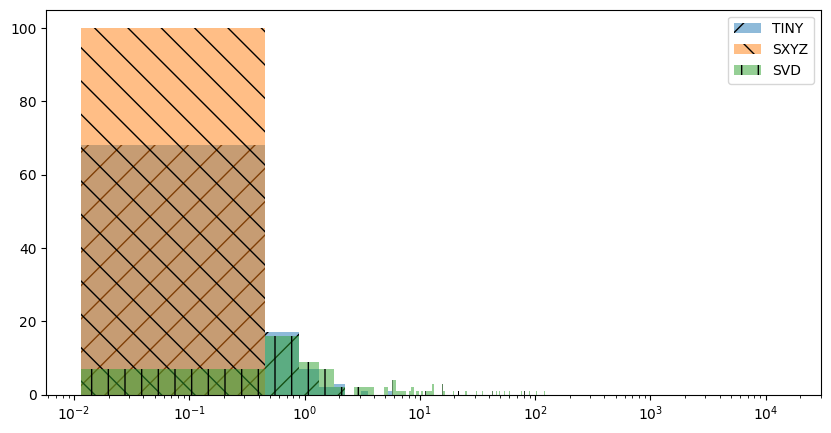

In [13]:
tf = torch.float32
n = 100000
results = agglomerate_results[(tf, n)]

# Plot histograms
# get the bins for all histograms
all_samples = np.concatenate([res for res in results.values()])
print(f"min: {all_samples.min():.2e}, max: {all_samples.max():.2e}")
bins = np.histogram_bin_edges(all_samples, bins='auto')
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]


plt.figure(figsize=(10, 5))
for name, res in results.items():
    plt.hist(res, bins=bins, alpha=0.5, label=name, hatch=patterns.pop(0))
plt.xscale('log')
plt.legend()

In [56]:
p = 200
d = 200
k = 10
n = p * d
print(n)

x, y = gen_data(n, p, d, k)

40000


In [58]:
%%timeit
solve_tiny(x, y, k)

31.4 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%%timeit
solve_nih(x, y, k, option=1)

212 ms ± 4.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
solve_svd_l2(x, y, k)

31 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%%timeit
solve_svd_l2(x, y, k)

29.8 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
%%timeit
solve_svd_l2_tl(x, y, k)

35.3 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
p = 200
d = 200
k = 10
n = p * d
print(n)

x, y = gen_data(n, p, d, k)
x = x.to(device=torch.device('cuda'))
y = y.to(device=torch.device('cuda'))

40000


In [49]:
%%timeit
solve_tiny(x, y, k)

233 ms ± 87.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit
solve_nih(x, y, k, option=1)

521 ms ± 845 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
solve_svd_l2(x, y, k)

339 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
solve_svd_l2_tl(x, y, k)

339 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
